[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/dsp_2025/blob/main/notebook_05.ipynb)

# **Cuaderno de Clase: Redes Neuronales Convolucionales para Imágenes Médicas**

## Marcos Carnerero Blanco 22M039 y Sergio Gil Atienza 22M047

**Objetivo:** Comprender cómo las redes neuronales convolucionales (CNN) aplican los principios de convolución para extraer características automáticas de imágenes médicas. Los estudiantes aprenderán a cargar datos DICOM (radiografías), preprocesarlos, y utilizar modelos pre-entrenados para análisis y clasificación de imágenes médicas.

**Librerías utilizadas:**
*   `pydicom`: Para leer archivos DICOM [1].
*   `NumPy` y `SciPy`: Para manipulación de datos.
*   `scikit-image`: Para procesamiento y redimensionamiento de imágenes.
*   `PyTorch`: Framework de aprendizaje profundo para implementar y utilizar redes neuronales [1].
*   `Torchvision`: Proporciona modelos pre-entrenados y herramientas de visión por computador.
*   `Matplotlib`: Para visualización.

### **2. Carga y Lectura de Archivos DICOM**

In [41]:
# --- Instalación de librerías necesarias ---
#!pip install pydicom torch torchvision torchinfo

# --- Importaciones ---
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dicom
from skimage.transform import resize
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchinfo import summary
import pandas as pd
import os
import glob

# Verificar si GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo disponible: {device}")

Dispositivo disponible: cuda


In [42]:
# Download data

#!pip install gdown
#!gdown --id 1whdnMdI6qkW-0kypplMFnWB2VWxyHUFF -O dsp.zip

In [43]:
#!unzip dsp.zip

***

### **1. Introducción a las Redes Neuronales Convolucionales (CNN)**

**¿Qué son las CNN?**
Las redes neuronales convolucionales son una clase especializada de redes neuronales diseñadas para procesar datos con una estructura de grilla, como las imágenes. A diferencia de los kernels manualmente diseñados que vimos en cuadernos anteriores, las CNN **aprenden automáticamente** los kernels más útiles para la tarea específica durante el entrenamiento.

**Componentes principales de una CNN:**
*   **Capas Convolucionales (Conv2D):** Aplican convoluciones con kernels aprendibles. Cada kernel detecta características diferentes (bordes, texturas, patrones).
*   **Funciones de Activación (ReLU):** Introducen no-linealidad, permitiendo que la red aprenda relaciones complejas.
*   **Capas de Pooling:** Reducen la dimensionalidad, extrayendo las características más relevantes.
*   **Capas Completamente Conectadas:** Procesan las características extraídas para hacer predicciones.

**¿Por qué son útiles para imágenes médicas?**
Las CNN pueden aprender a identificar patrones sutiles que diferencian a pacientes sanos de enfermos, pueden detectar anomalías con alta precisión y generalizan bien a nuevas imágenes.

***

=== Información del Archivo DICOM ===
Sexo del paciente: M
Edad del paciente: 054Y
Dimensiones de imagen: (3072, 3072)
Rango de valores de píxeles: [0, 16383]


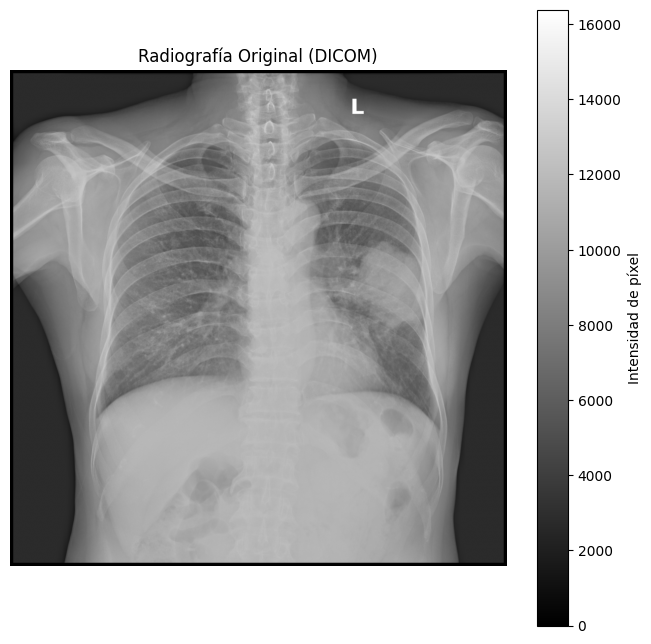

In [44]:
def read_dicom(file_path):
    """
    Lee un archivo DICOM y extrae la imagen y los metadatos.

    Parámetros:
    -----------
    file_path : str
        Ruta al archivo DICOM.

    Retorna:
    --------
    metadata : pydicom.Dataset
        Metadatos del archivo DICOM.
    image_data : np.ndarray
        Array de píxeles de la imagen.
    """
    metadata = dicom.dcmread(file_path)
    image_data = metadata.pixel_array
    return metadata, image_data

# --- Ejemplo: Cargar una radiografía ---
# Reemplaza con tu propia ruta a un archivo DICOM
dcm_file = './dsp/04031e57794b9e8861e3c65e935f11d2.dcm'

metadata, xray_image = read_dicom(dcm_file)

# Mostrar información clínica
print("=== Información del Archivo DICOM ===")
#print(f"Modalidad: {metadata.Modality}")
print(f"Sexo del paciente: {metadata.PatientSex if 'PatientSex' in metadata else 'No disponible'}")
print(f"Edad del paciente: {metadata.PatientAge if 'PatientAge' in metadata else 'No disponible'}")
print(f"Dimensiones de imagen: {xray_image.shape}")
print(f"Rango de valores de píxeles: [{xray_image.min()}, {xray_image.max()}]")

# --- Visualizar la radiografía original ---
plt.figure(figsize=(8, 8))
plt.imshow(xray_image, cmap='gray')
plt.title('Radiografía Original (DICOM)')
plt.colorbar(label='Intensidad de píxel')
plt.axis('off')
plt.show()

***

### **3. Preprocesamiento de Imágenes Médicas**

El preprocesamiento es crucial para normalizar la entrada a los modelos de aprendizaje profundo. Esto incluye redimensionamiento, normalización y conversión de formatos.


Preprocesando imagen...
Forma después del preprocesamiento: (1, 3, 224, 224)
Estadísticas después de la normalización:
  Media: -0.0000
  Desviación estándar: 1.0000


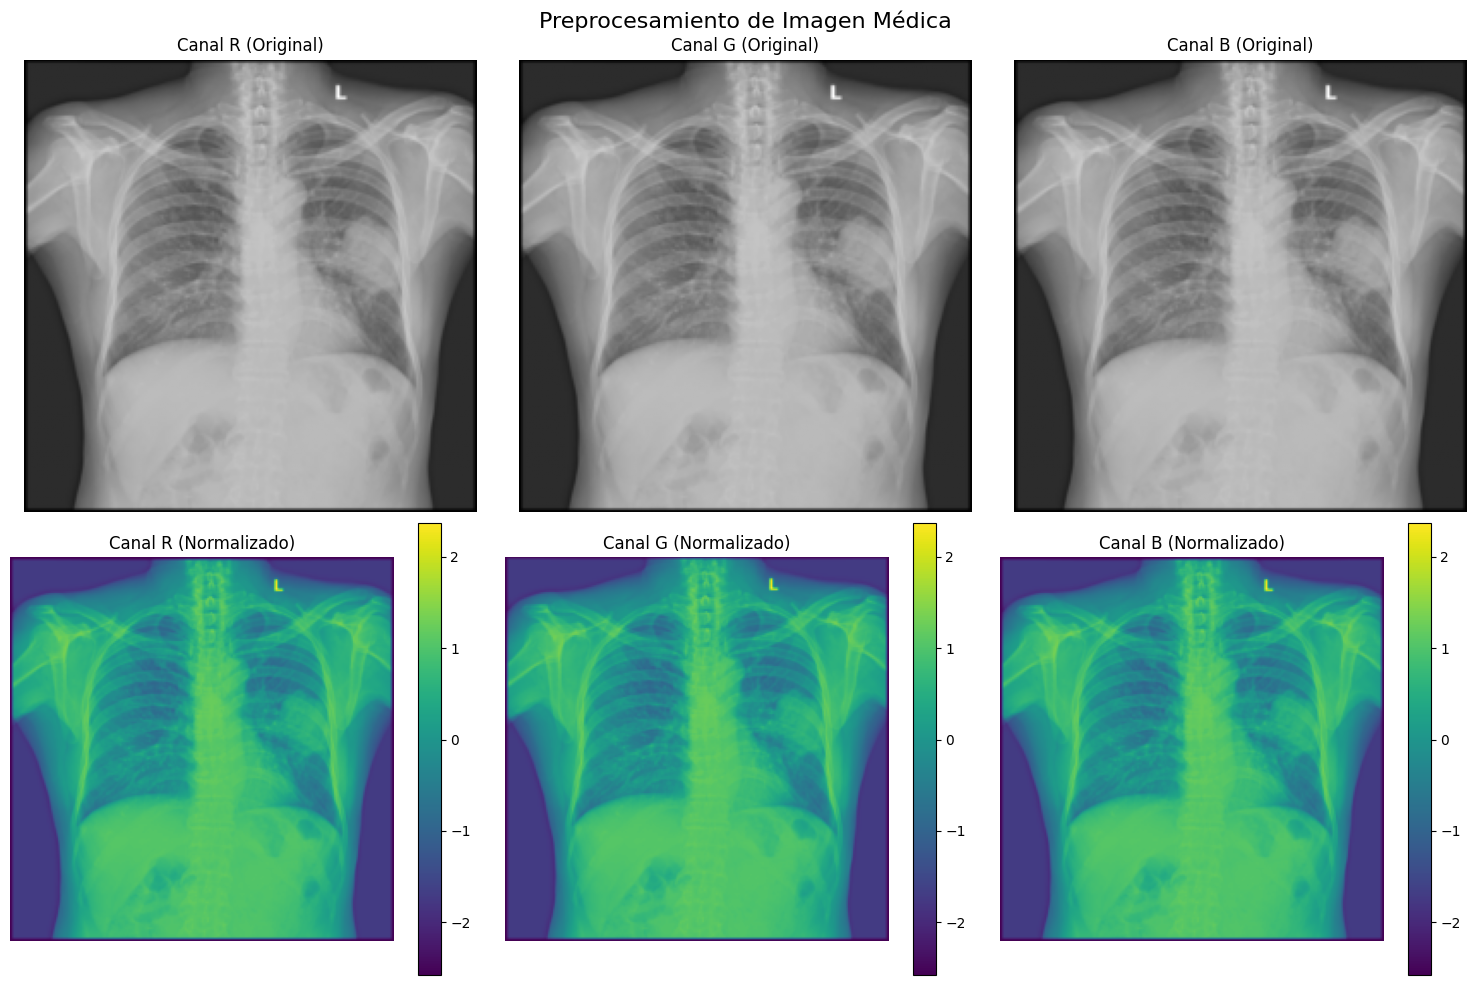

In [45]:
def grayscale_to_rgb(img):
    """
    Convierte una imagen en escala de grises a RGB (3 canales).
    Necesario para modelos pre-entrenados como VGG16 que esperan 3 canales.

    Parámetros:
    -----------
    img : np.ndarray
        Imagen en escala de grises de forma (H, W).

    Retorna:
    --------
    img_rgb : np.ndarray
        Imagen RGB de forma (H, W, 3), con el mismo contenido en los 3 canales.
    """
    img_rgb = np.repeat(np.expand_dims(img, -1), 3, axis=2)
    return img_rgb

def preprocess_image(img):
    """
    Preprocesa una imagen para entrada a una CNN.

    Pasos:
    1. Normaliza a [0, 1].
    2. Redimensiona a 224x224 (tamaño estándar para VGG16 y ResNet).
    3. Convierte a formato PyTorch: (Batch, Canales, Alto, Ancho).
    4. Normaliza estadísticamente (restando media y dividiendo por desviación estándar).

    Parámetros:
    -----------
    img : np.ndarray
        Imagen original.

    Retorna:
    --------
    x : np.ndarray
        Imagen preprocesada lista para la CNN.
    """
    # Paso 1: Normalizar a [0, 1]
    img_normalized = img / np.max(img) if np.max(img) > 0 else img

    # Paso 2: Redimensionar
    img_resized = resize(img_normalized, (224, 224), preserve_range=True)
    img_resized = (img_resized * 255).astype(np.uint8)

    # Paso 3: Convertir a RGB
    img_rgb = grayscale_to_rgb(img_resized)

    # Paso 4: Formato PyTorch y normalización estadística
    x = np.expand_dims(img_rgb, axis=0)  # Añadir dimensión de batch: (1, H, W, C)
    x = np.rollaxis(x, 3, 1)  # Reordenar: (1, C, H, W)
    x = x.astype(np.float32)

    # Normalización: restar media y dividir por desviación estándar
    x = x - x.mean()
    x = x / (x.std() + 1e-8)  # Evitar división por cero

    return x

# --- Aplicar preprocesamiento ---
print("Preprocesando imagen...")
x_preprocessed = preprocess_image(xray_image)

print(f"Forma después del preprocesamiento: {x_preprocessed.shape}")
print(f"Estadísticas después de la normalización:")
print(f"  Media: {x_preprocessed.mean():.4f}")
print(f"  Desviación estándar: {x_preprocessed.std():.4f}")

# --- Visualizar canales originales y preprocesados ---
img_resized = resize(xray_image / np.max(xray_image), (224, 224), preserve_range=True)
img_resized = (img_resized * 255).astype(np.uint8)
img_rgb = grayscale_to_rgb(img_resized)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Preprocesamiento de Imagen Médica', fontsize=16)

# Fila 1: Imagen RGB redimensionada
axes[0, 0].imshow(img_rgb[:, :, 0], cmap='gray')
axes[0, 0].set_title('Canal R (Original)')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_rgb[:, :, 1], cmap='gray')
axes[0, 1].set_title('Canal G (Original)')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_rgb[:, :, 2], cmap='gray')
axes[0, 2].set_title('Canal B (Original)')
axes[0, 2].axis('off')

# Fila 2: Imagen normalizada estadísticamente
normalized_r = np.squeeze(x_preprocessed)[0, :, :]
normalized_g = np.squeeze(x_preprocessed)[1, :, :]
normalized_b = np.squeeze(x_preprocessed)[2, :, :]

im1 = axes[1, 0].imshow(normalized_r, cmap='viridis')
axes[1, 0].set_title('Canal R (Normalizado)')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(normalized_g, cmap='viridis')
axes[1, 1].set_title('Canal G (Normalizado)')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1])

im3 = axes[1, 2].imshow(normalized_b, cmap='viridis')
axes[1, 2].set_title('Canal B (Normalizado)')
axes[1, 2].axis('off')
plt.colorbar(im3, ax=axes[1, 2])

plt.tight_layout()
plt.show()

### **4. Modelos Pre-entrenados: VGG16**

Un **modelo pre-entrenado** es una red neuronal que ya ha sido entrenada en un dataset muy grande (como ImageNet con 14 millones de imágenes). Estos modelos han aprendido características visuales genéricas que son transferibles a nuevas tareas.

**Transfer Learning:** El concepto de reutilizar un modelo pre-entrenado en una nueva tarea se llama "transfer learning". Esto es extremadamente útil cuando tenemos pocos datos de entrenamiento específicos de la tarea.


In [46]:
# --- Descargar y cargar VGG16 pre-entrenado ---
print("Descargando modelo VGG16 pre-entrenado...")
model_vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model_vgg16.eval()  # Modo de evaluación (sin dropout, etc.)
model_vgg16.to(device)

print("\n=== Arquitectura de VGG16 ===")
print(model_vgg16)

# --- Obtener resumen de la arquitectura ---
print("\n=== Resumen de Capas ===")
summary(model_vgg16, input_size=(1, 3, 224, 224))

Descargando modelo VGG16 pre-entrenado...

=== Arquitectura de VGG16 ===
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

**Interpretación de la arquitectura:**
*   **Capas Convolucionales (Conv2d):** Cada una tiene un nombre como "Conv2d(64, 128, kernel_size=(3, 3))". Esto significa que toma 64 canales de entrada y produce 128 canales de salida usando kernels 3x3.
*   **ReLU:** Activación rectificada lineal.
*   **MaxPool2d:** Reduce el tamaño de la imagen a la mitad en cada dimensión.
*   **Capas completamente conectadas (Linear):** Las tres últimas capas (4096 → 4096 → 1000) clasifican las características extraídas. El número 1000 corresponde a las 1000 clases de ImageNet.


In [47]:
# --- Usar VGG16 para extraer características ---
def extract_features(image_array, model, device):
    """
    Extrae características de una imagen usando el modelo.

    Parámetros:
    -----------
    image_array : np.ndarray
        Imagen preprocesada de forma (1, 3, 224, 224).
    model : torch.nn.Module
        Modelo de la CNN.
    device : torch.device
        Dispositivo (CPU o GPU).

    Retorna:
    --------
    features : np.ndarray
        Vector de características de forma (1, 1000).
    """
    # Convertir a tensor de PyTorch
    image_tensor = torch.from_numpy(image_array).to(device)

    # Realizar predicción (forward pass)
    with torch.no_grad():  # No calcular gradientes (más rápido)
        output = model(image_tensor)

    # Convertir de vuelta a NumPy
    features = output.cpu().numpy()
    return features

# --- Extraer características de la imagen ---
features = extract_features(x_preprocessed, model_vgg16, device)

print(f"Vector de características: forma {features.shape}")

# --- Obtener la predicción ---
predicted_class_idx = np.argmax(features[0])
print(f"\nClase predicha (índice): {predicted_class_idx}")
print(f"Confianza: {features[0, predicted_class_idx]:.4f}")

Vector de características: forma (1, 1000)

Clase predicha (índice): 749
Confianza: 12.6049


***

### **5. Visualización de Activaciones de Capas Convolucionales**

Una forma de entender qué está "aprendiendo" la CNN es visualizar las activaciones (salidas) de las capas convolucionales. Cada mapa de características representa lo que la red "ve" a ese nivel de abstracción.


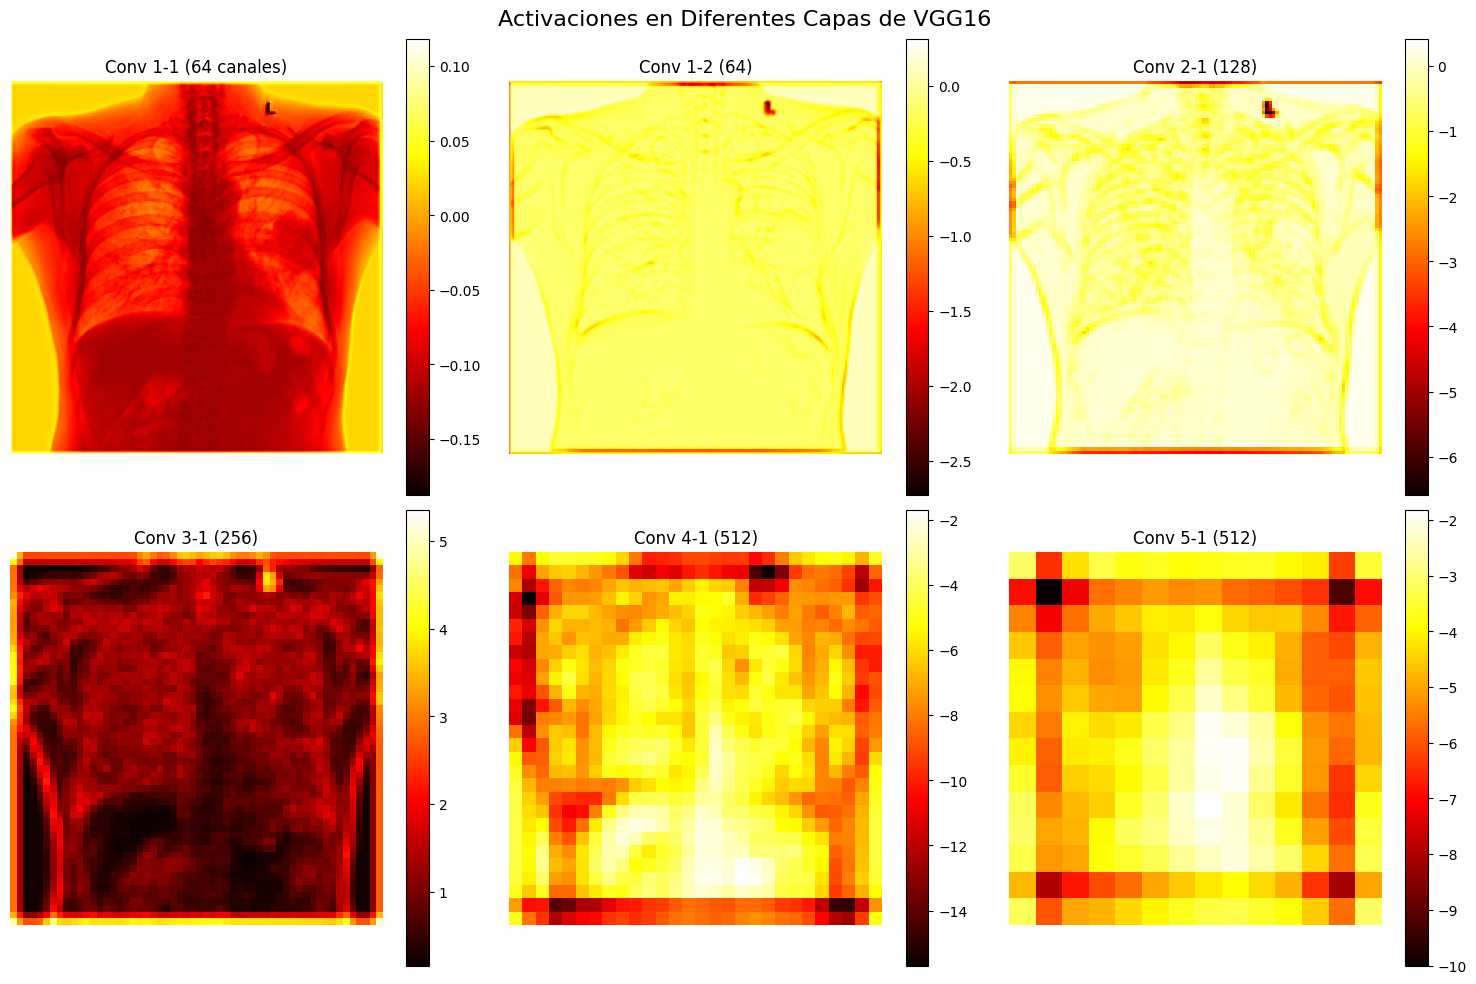

Observación: Las primeras capas detectan características simples (bordes).
Las capas más profundas detectan características más complejas y abstractas.


In [48]:
def get_layer_output(image_array, model, device, layer_name):
    """
    Extrae la salida de una capa específica.

    Parámetros:
    -----------
    image_array : np.ndarray
        Imagen preprocesada.
    model : torch.nn.Module
        Modelo.
    device : torch.device
        Dispositivo (CPU o GPU).
    layer_name : str
        Nombre de la capa dentro de model.features (ej. "0", "5", "10").

    Retorna:
    --------
    output : np.ndarray
        Salida de la capa.
    """
    image_tensor = torch.from_numpy(image_array).to(device)

    # Usar torch.nn.Sequential para acceder a capas intermedias
    intermediate_model = nn.Sequential(*list(model.features.children())[:int(layer_name)+1])

    with torch.no_grad():
        output = intermediate_model(image_tensor)

    return output.cpu().numpy()

# --- Visualizar activaciones de diferentes capas ---
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Activaciones en Diferentes Capas de VGG16', fontsize=16)

layer_indices = [0, 2, 5, 9, 17, 24]  # Índices de capas convolucionales
layer_labels = ['Conv 1-1 (64 canales)', 'Conv 1-2 (64)', 'Conv 2-1 (128)',
                'Conv 3-1 (256)', 'Conv 4-1 (512)', 'Conv 5-1 (512)']

for idx, (layer_idx, label) in enumerate(zip(layer_indices, layer_labels)):
    ax = axes[idx // 3, idx % 3]

    # Obtener activaciones
    activation = get_layer_output(x_preprocessed, model_vgg16, device, str(layer_idx))

    # Visualizar el promedio de todos los mapas de características
    feature_map_avg = np.mean(activation[0], axis=0)

    im = ax.imshow(feature_map_avg, cmap='hot')
    ax.set_title(label)
    ax.axis('off')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("Observación: Las primeras capas detectan características simples (bordes).")
print("Las capas más profundas detectan características más complejas y abstractas.")

### **6. Ejercicios Propuestos**

**Ejercicio 1: Comparación de Modelos Pre-entrenados**
1.  Descarga otros modelos pre-entrenados: `ResNet50` y `DenseNet121`.
2.  Para la misma radiografía, extrae características usando los tres modelos (VGG16, ResNet50, DenseNet121).
3.  Compara los vectores de características: ¿Son similares? ¿En qué se diferencian?
4.  Documenta el número de parámetros de cada modelo usando `summary()`.

In [49]:
# --- Descargar y cargar ResNet50 pre-entrenado ---
print("Descargando modelo ResNet50 pre-entrenado...")
model_resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model_resnet50.eval()  # Modo de evaluación (sin dropout, etc.)
model_resnet50.to(device)

print("\n=== Arquitectura de ResNet50 ===")
print(model_resnet50)

# --- Obtener resumen de la arquitectura ---
print("\n=== Resumen de Capas ===")
summary(model_resnet50, input_size=(1, 3, 224, 224))

Descargando modelo ResNet50 pre-entrenado...

=== Arquitectura de ResNet50 ===
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsa

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [50]:
# --- Descargar y cargar DenseNet121 pre-entrenado ---
print("Descargando modelo DenseNet121 pre-entrenado...")
model_densenet121 = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model_densenet121.eval()  # Modo de evaluación (sin dropout, etc.)
model_densenet121.to(device)

print("\n=== Arquitectura de DenseNet121 ===")
print(model_densenet121)

# --- Obtener resumen de la arquitectura ---
print("\n=== Resumen de Capas ===")
summary(model_densenet121, input_size=(1, 3, 224, 224))

Descargando modelo DenseNet121 pre-entrenado...

=== Arquitectura de DenseNet121 ===
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNor

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 56, 56]     

In [51]:
print("\n=== Resultados VGG16 ===")
# --- Extraer características de la imagen ---
features_vgg16 = extract_features(x_preprocessed, model_vgg16, device)

print(f"Vector de características: forma {features_vgg16.shape}")

# --- Obtener la predicción ---
predicted_class_idx = np.argmax(features_vgg16[0])
print(f"\nClase predicha (índice): {predicted_class_idx}")
print(f"Confianza: {features_vgg16[0, predicted_class_idx]:.4f}")


=== Resultados VGG16 ===
Vector de características: forma (1, 1000)

Clase predicha (índice): 749
Confianza: 12.6049


In [52]:
print("\n=== Resultados ResNet50 ===")
# --- Extraer características de la imagen ---
features_resnet50 = extract_features(x_preprocessed, model_resnet50, device)

print(f"Vector de características: forma {features_resnet50.shape}")

# --- Obtener la predicción ---
predicted_class_idx = np.argmax(features_resnet50[0])
print(f"\nClase predicha (índice): {predicted_class_idx}")
print(f"Confianza: {features_resnet50[0, predicted_class_idx]:.4f}")


=== Resultados ResNet50 ===
Vector de características: forma (1, 1000)

Clase predicha (índice): 112
Confianza: 3.8798


In [53]:
print("\n=== Resultados DenseNet121 ===")
# --- Extraer características de la imagen ---
features_densenet121 = extract_features(x_preprocessed, model_densenet121, device)

print(f"Vector de características: forma {features_densenet121.shape}")

# --- Obtener la predicción ---
predicted_class_idx = np.argmax(features_densenet121[0])
print(f"\nClase predicha (índice): {predicted_class_idx}")
print(f"Confianza: {features_densenet121[0, predicted_class_idx]:.4f}")


=== Resultados DenseNet121 ===
Vector de características: forma (1, 1000)

Clase predicha (índice): 905
Confianza: 8.5776


Para calcular los vectores de resultados entre sí podemos utilizar, por ejemplo, la distancia entre ellos y la correlación.

In [54]:
print("Dist. VGG16 vs ResNet50:", np.linalg.norm(features_vgg16 - features_resnet50) / len(features_vgg16[0]))
print("Dist. VGG16 vs DenseNet121:", np.linalg.norm(features_vgg16 - features_densenet121) / len(features_vgg16[0]))
print("Dist. ResNet50 vs DenseNet121:", np.linalg.norm(features_resnet50 - features_densenet121) / len(features_vgg16[0]))
print()
print("Corr. VGG16 vs ResNet50:", np.corrcoef(features_vgg16, features_resnet50)[0, 1])
print("Corr. VGG16 vs DenseNet121:", np.corrcoef(features_vgg16, features_densenet121)[0, 1])
print("Corr. ResNet50 vs DenseNet121:", np.corrcoef(features_resnet50, features_densenet121)[0, 1])

Dist. VGG16 vs ResNet50: 0.085643224
Dist. VGG16 vs DenseNet121: 0.06446525
Dist. ResNet50 vs DenseNet121: 0.068830766

Corr. VGG16 vs ResNet50: 0.5642988795705881
Corr. VGG16 vs DenseNet121: 0.7437130191401845
Corr. ResNet50 vs DenseNet121: 0.5740568917757616


Podemos apreciar como los vectores más cercanos son los de VGG16 y DenseNet121, que también son los que tienen una mayor correlación entre sí. ResNet50 y DenseNet121 también están a una distancia similar a la anterior, aunque la correlación entre ellos es mucho peor. VGG16 y ResNet50 tienen baja correlación y son lejanos entre sí, dando los resultados más dispares.

Observamos también como VGG16 y DenseNet121 dan su resultado con una alta confianza (12,6049 y 8,5776), mientras que ResNet50 duda sobre la predicción, dando una baja confianza (3,8798). En general, parece ser que VGG16 y DenseNet121 otorgan una alta confianza, mientras ResNet50 produce valores más cercanos a 0.

In [55]:
summary(model_vgg16)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [56]:
summary(model_resnet50)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [57]:
summary(model_densenet121)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             45,440
│    │    └─_DenseLayer: 3-2             49,600
│    │    └─_DenseLayer: 3-3             53,760
│    │    └─_DenseLayer: 3-4             57,920
│    │    └─_DenseLayer: 3-5             62,080
│    │    └─_DenseLayer: 3-6             66,240
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             512
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  32,768
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            53,760
│    │    └─_DenseLayer: 3-12     

**Ejercicio 2: Análisis de Sensibilidad del Preprocesamiento**
1.  Preprocesa la misma imagen con diferentes técnicas:
    - Sin normalización estadística.
    - Con normalización estadística.
2.  Para cada variante, extrae características con VGG16.
3.  Calcula la similitud (correlación o distancia euclidiana) entre los vectores de características.
4.  Escribe una conclusión sobre qué tan sensible es el modelo a cambios en el preprocesamiento.

In [58]:
def preprocess_image(img, normalize=True):
    """
    Preprocesa una imagen para entrada a una CNN.

    Pasos:
    1. Normaliza a [0, 1].
    2. Redimensiona a 224x224 (tamaño estándar para VGG16 y ResNet).
    3. Convierte a formato PyTorch: (Batch, Canales, Alto, Ancho).
    4. Normaliza estadísticamente (restando media y dividiendo por desviación estándar).

    Parámetros:
    -----------
    img : np.ndarray
        Imagen original.

    Retorna:
    --------
    x : np.ndarray
        Imagen preprocesada lista para la CNN.
    """
    # Paso 1: Normalizar a [0, 1]
    img_normalized = img / np.max(img) if np.max(img) > 0 else img

    # Paso 2: Redimensionar
    img_resized = resize(img_normalized, (224, 224), preserve_range=True)
    img_resized = (img_resized * 255).astype(np.uint8)

    # Paso 3: Convertir a RGB
    img_rgb = grayscale_to_rgb(img_resized)

    # Paso 4: Formato PyTorch y normalización estadística
    x = np.expand_dims(img_rgb, axis=0)  # Añadir dimensión de batch: (1, H, W, C)
    x = np.rollaxis(x, 3, 1)  # Reordenar: (1, C, H, W)
    x = x.astype(np.float32)

    # Normalización: restar media y dividir por desviación estándar
    if (normalize):
        x = x - x.mean()
        x = x / (x.std() + 1e-8)  # Evitar división por cero

    return x

# --- Aplicar preprocesamiento sin normalización---
print("Preprocesando imagen sin normalización...")
x_preprocessed_not_normalized = preprocess_image(xray_image, False)

print(f"Forma después del preprocesamiento: {x_preprocessed_not_normalized.shape}")
print(f"Estadísticas después de la normalización:")
print(f"  Media: {x_preprocessed_not_normalized.mean():.4f}")
print(f"  Desviación estándar: {x_preprocessed_not_normalized.std():.4f}")

Preprocesando imagen sin normalización...
Forma después del preprocesamiento: (1, 3, 224, 224)
Estadísticas después de la normalización:
  Media: 129.1314
  Desviación estándar: 50.0853


In [59]:
print("\n=== Resultados VGG16  sin normalización===")
# --- Extraer características de la imagen ---
features = extract_features(x_preprocessed_not_normalized, model_vgg16, device)

print(f"Vector de características: forma {features.shape}")

# --- Obtener la predicción ---
predicted_class_idx = np.argmax(features[0])
print(f"\nClase predicha (índice): {predicted_class_idx}")
print(f"Confianza: {features[0, predicted_class_idx]:.4f}")


=== Resultados VGG16  sin normalización===
Vector de características: forma (1, 1000)

Clase predicha (índice): 818
Confianza: 125.4635


In [60]:
print("\n=== Resultados VGG16 con normalización===")
# --- Extraer características de la imagen ---
features_norm = extract_features(x_preprocessed, model_vgg16, device)

print(f"Vector de características: forma {features_norm.shape}")

# --- Obtener la predicción ---
predicted_class_idx = np.argmax(features_norm[0])
print(f"\nClase predicha (índice): {predicted_class_idx}")
print(f"Confianza: {features_norm[0, predicted_class_idx]:.4f}")


=== Resultados VGG16 con normalización===
Vector de características: forma (1, 1000)

Clase predicha (índice): 749
Confianza: 12.6049


In [61]:
print("Distancia:", np.linalg.norm(features - features_norm) / len(features[0]))
print("Correlación:", np.corrcoef(features, features_norm)[0, 1])

Distancia: 0.7909148
Correlación: 0.5546377084156056


Podemos ver que el modelo es altamente sensible a los cambios de normalización, cambiando incluso por ordenes de magnitud. La distancia entre ambos métodos es muy alta, y la correlación se reduce sólo a la mitad.

**Ejercicio 3: Visualización de Mapas de Características por Canal**
1.  En lugar de promediar todos los mapas de características de una capa, visualiza los primeros 9 mapas individuales.
2.  ¿Qué patrones detectas? ¿Algunos mapas se especializan en ciertos tipos de características?

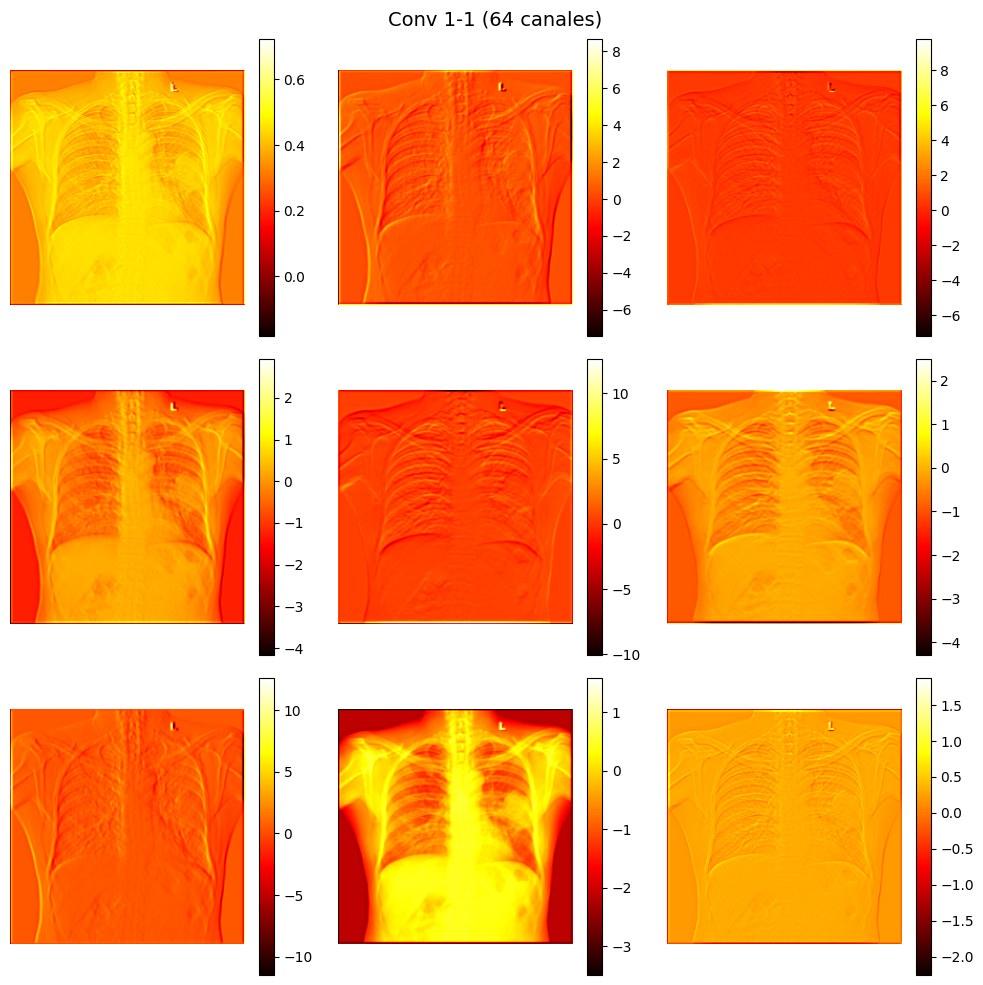

In [62]:
# --- Visualizar activaciones de diferentes capas ---
import numpy as np
import matplotlib.pyplot as plt

layer_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
layer_labels = ['Conv 1-1 (64 canales)']

for layer_idx, label in zip(layer_indices, layer_labels):
    activation = get_layer_output(x_preprocessed, model_vgg16, device, str(layer_idx))
    act = activation[0]
    act = np.array(act)
    num_maps = min(9, act.shape[0])
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(label, fontsize=14)
    for i in range(9):
        ax = axes[i // 3, i % 3]
        if i < num_maps:
            fm = act[i]
            im = ax.imshow(fm, cmap='hot')
            ax.axis('off')
            fig.colorbar(im, ax=ax)
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

Podemos ver que los mapas son bastante variados. Algunos parecer priorizar las estructuras internas (8), otros enfatizan los huesos (1, 4, 6) y, entre otras cosas, también hay para lo que parece ser detección de bordes (2), volumen (7), etc.